In [1]:
import glob
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Wczytanie wyników optymalizacji

In [2]:
data_set_names = {
    '720' : 'abalone',
    '1037' : 'ada_prior',
    '1489' : 'phoneme',
    '44' : 'spambase'
}

data_folder = 'data'
data = {}

file_pattern = f'*-*-*-0.csv'
file_paths = glob.glob(os.path.join(data_folder, file_pattern))
for file_path in file_paths:
    filename = os.path.basename(file_path)
    method, id, algorithm, _ = filename.split('-')
    df = pd.read_csv(file_path, sep=';')
    df = df.iloc[:, :-1]

    df.name = data_set_names[id]

    if(data.get(algorithm) is None):
        data[algorithm] = {}

    if(data[algorithm].get(method) is None):
        data[algorithm][method] = []

    data[algorithm][method].append(df)

Obliczenie średnio najlepszego zestawu hiperparametrów per algorytm oraz zapisanie jego indeksu

In [3]:
best_configuration_index_per_algorithm = {}

for algorithm in data.keys():
    data_sets = data[algorithm]['random_search']
    scores = data_sets[0].iloc[:, -1]

    for i in range(1, len(data_sets)):
        other_data_set = data_sets[i]
        last_column = other_data_set.iloc[:, -1]
        scores = pd.concat([scores, last_column], axis=1)

    last_columns = scores.iloc[:, -len(data_sets):]
    
    max_avg_index = last_columns.mean(axis=1).idxmax()
    best_configuration = scores.loc[max_avg_index]
    best_configuration_index_per_algorithm[algorithm] = max_avg_index

Ustawienie odpowiedniej czcionki na wykresach

In [4]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 12,
})

Obliczenie tunowalności per iteracja dla Random Search

In [53]:
for algorithm in data.keys():
    data_sets = data[algorithm]['random_search']
    
    for i in range(len(data_sets)):
        diff = data_sets[i]['Srednia dokladnosc'][best_configuration_index_per_algorithm[algorithm]] - data_sets[i]['Srednia dokladnosc']
        data_sets[i]['Differents'] = diff

Obliczenie tunowalności per iteracja dla optymalizacji bayesowskiej

In [44]:
for algorithm in data.keys():
    data_sets = data[algorithm]['bayes_search']
    rs_data_sets = data[algorithm]['random_search']
    
    for i in range(len(data_sets)):
        diff = rs_data_sets[i]['Srednia dokladnosc'][best_configuration_index_per_algorithm[algorithm]] - data_sets[i]['Srednia dokladnosc']
        data_sets[i]['Differents'] = diff

Wykreślenie boxplotów tunowalności

In [60]:
fig, axes = plt.subplots(3, 2, figsize=(12, 13.5))
plt.ioff()

p = 0

for algorithm in data.keys():
    data_sets = data[algorithm]['random_search']
    
    diffs_to_plot = []
    labels = []

    for i in range(len(data_sets)):
        diffs_to_plot.append(data_sets[i]['Differents'])
        labels.append(data_sets[i].name)

    axes[p, 0].boxplot(diffs_to_plot, labels=labels)
    axes[p, 0].set_title(f'Random Search for {algorithm}', pad=10)

    p = p + 1

p = 0

for algorithm in data.keys():
    data_sets = data[algorithm]['bayes_search']
    
    diffs_to_plot = []
    labels = []

    for i in range(len(data_sets)):
        diffs_to_plot.append(data_sets[i]['Differents'])
        labels.append(data_sets[i].name)
    
    axes[p, 1].boxplot(diffs_to_plot, labels=labels)
    axes[p, 1].set_title(f'Bayes Search for {algorithm}', pad=10)

    p = p + 1

plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.savefig(f'box-plots.svg', bbox_inches='tight', pad_inches=0.2)
plt.close()

Obliczenie tunowalności dla Random Search

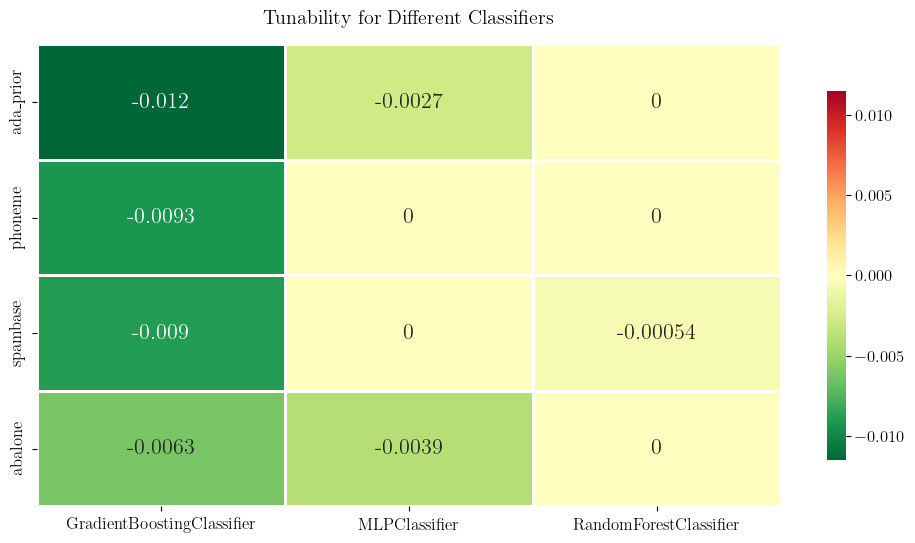

In [15]:
tunability = pd.DataFrame()

for algorithm in data.keys():
    tunability[algorithm] = {}
    data_sets = data[algorithm]['random_search']

    diffs = []

    for data_set in data_sets:
        best_value = data_set['Srednia dokladnosc'].max()
        diff = data_set['Srednia dokladnosc'][best_configuration_index_per_algorithm[algorithm]] - best_value
        diffs.append(diff)
    
    tunability[algorithm] = diffs

y_labels = [dataset.name for dataset in data_sets]

plt.figure(figsize=(12, 6))
heatmap = sns.heatmap(tunability, yticklabels=y_labels, annot=True, cmap="RdYlGn_r", linewidths=1, center=0, vmax=-tunability.min().min(), annot_kws={'size': 16}, cbar_kws={"shrink": 0.8})


heatmap.yaxis.set_tick_params(pad=5)
heatmap.xaxis.set_tick_params(pad=5)

plt.title('Tunability for Different Classifiers', pad=15)
plt.savefig('rs_heatmap.svg', bbox_inches='tight', pad_inches=0.2)

Obliczenie tunowalności dla optymalizacji bayesowskiej

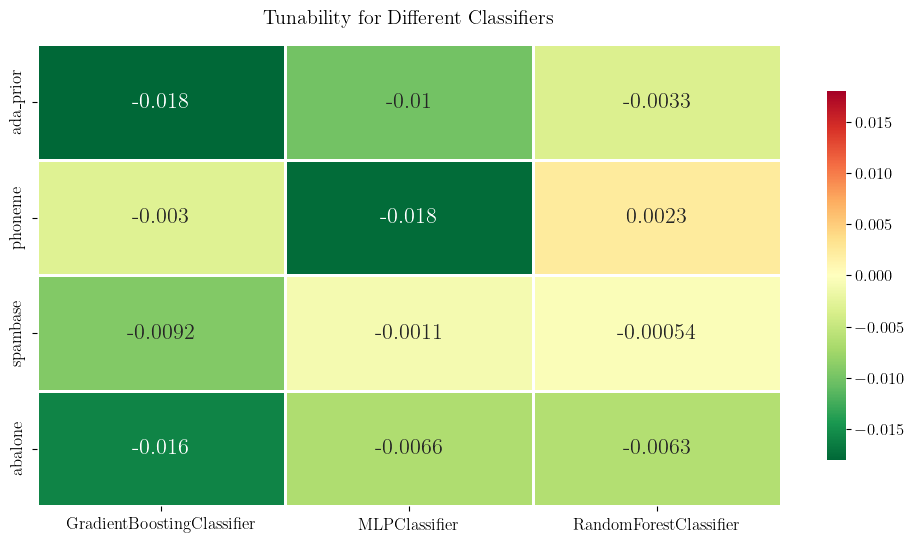

In [9]:
tunability = pd.DataFrame()

for algorithm in data.keys():
    tunability[algorithm] = {}
    data_sets = data[algorithm]['bayes_search']
    rs_data_sets = data[algorithm]['random_search']

    diffs = []

    for i in range(len(data_sets)):
        data_set = data_sets[i]
        best_value = data_set['Srednia dokladnosc'].max()
        diff = rs_data_sets[i]['Srednia dokladnosc'][best_configuration_index_per_algorithm[algorithm]] - best_value
        diffs.append(diff)
    
    tunability[algorithm] = diffs

y_labels = [dataset.name for dataset in data_sets]

plt.figure(figsize=(12, 6))
heatmap = sns.heatmap(tunability, yticklabels=y_labels, annot=True, cmap="RdYlGn_r", linewidths=1, center=0, vmax=-tunability.min().min(), annot_kws={'size': 16}, cbar_kws={"shrink": 0.8})

heatmap.yaxis.set_tick_params(pad=5)
heatmap.xaxis.set_tick_params(pad=5)

plt.title('Tunability for Different Classifiers', pad=15)
plt.savefig('bs_heatmap.svg', bbox_inches='tight', pad_inches=0.2)

Narysowanie wykresu zbieżności dla poszczególnych algorytmów i zbiorów danych w optymalizacji bayesowskiej

In [35]:
labels = [data for data in data.keys()]

fig, axes = plt.subplots(2, 2, figsize=(12, 9))

for i in range(len(data_sets)):

    handles = []

    for algorithm in data.keys():
        data_sets = data[algorithm]['bayes_search']
        current_data_set = data_sets[i]

        current_best = 0
        current_index = 0
        y = []
        x = []

        for value in current_data_set['Srednia dokladnosc']:
            current_index += 1
            if(value >= current_best):
                y.append(value)
                x.append(current_index)

            if(value > current_best):
                current_best = value

        handle, = axes[i//2, i%2].plot(x, y)
        axes[i//2, i%2].scatter(x, y, s=15)
        handles.append(handle)
        axes[i//2, i%2].set_title(f'{data_sets[i].name}', pad=10)
    
    axes[i//2, i%2].legend(handles=handles, labels=labels)

plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.savefig(f'scatters/bs-convergence.svg', bbox_inches='tight', pad_inches=0.2)
plt.close()

Wykreślenie wykresu wyników dla poszczególnych iteracji dla Random Search

In [61]:
labels = [data for data in data.keys()]

for i in range(len(data_sets)):
    if i%2 == 0:
        fig, axes = plt.subplots(3, 2, figsize=(12, 13.5))

    for j, algorithm in enumerate(data.keys()):
        data_sets = data[algorithm]['random_search']
        current_data_set = data_sets[i]

        current_best = 0
        current_index = 0

        x = current_data_set['Iteracja']
        y = current_data_set['Srednia dokladnosc']

        axes[j, i%2].axvline(x[best_configuration_index_per_algorithm[algorithm]], color='blue', linestyle='-')
        axes[j, i%2].axvline(x[y.idxmax()], color='red', linestyle='--')
        axes[j, i%2].scatter(x, y, s=5)
        axes[j, i%2].set_title(f'{current_data_set.name} with {algorithm}', pad=10)

    if (i+1)%2 == 0:
        plt.subplots_adjust(hspace=0.3, wspace=0.3)
        plt.savefig(f'scattersRS/{data_sets[i-1].name}-{data_sets[i].name}.svg', bbox_inches='tight', pad_inches=0.2)
        plt.close()
